<a href="https://colab.research.google.com/github/Assistive-Technology-Create-Team/plumshum.github.io/blob/new_data_acquisition_and_machine_learning/modified_machine_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use this [FallALlID2.csv file](https://drive.google.com/file/d/1Oi4Y_-EtZxU9mOAn-v5a93EDW43gpS1n/view?usp=sharing). Make sure to upload your own version to your Google Drive. 

1. Install Packages
2. Mount Drive
3. Change Google Colab Runtime to use GPU

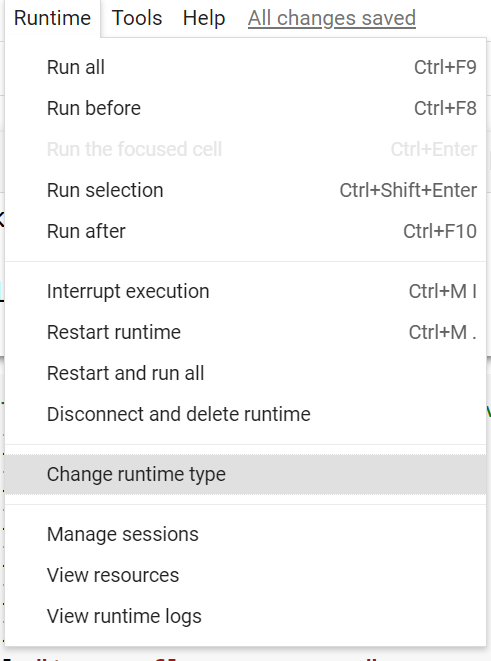
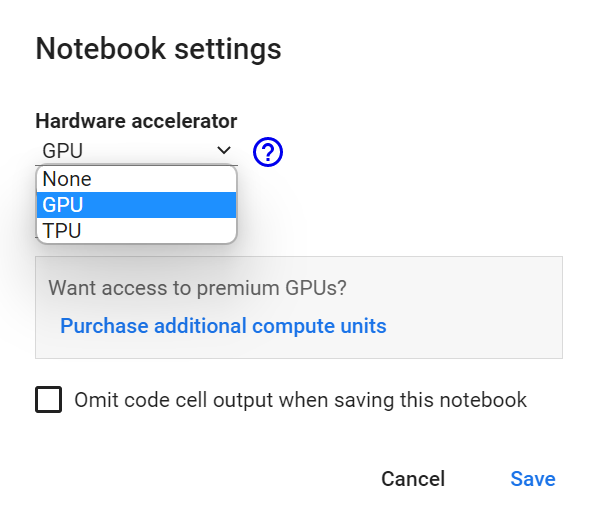

4. Run All the remaining cells until the 2nd to last one. This cell will run all the other functions
```
run_all()
```
5. The 3rd to last cell has a line

```
var = 0
x_train, x_test, y_train, y_test = data_split(df, var)
...
model = train_and_accurary_model(model, x_train, x_test, y_train, y_test, var)

```
Every time you execute `run_all()`, change the variable `var` by 1 until 6. `var` represent a different amount of features used. 

6. Every time a model is saved, it should be saved in your Google Drive, and you can manually save it to your local machine. 

In [ ]:
#Run to install packages. Will take a few minutes
%pip install numpy
%pip install pandas
%pip install os-sys
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install "tensorflow-gpu<2.10"
%pip install "tensorflow<2.10"
%pip install "keras<2.10"

In [3]:
# If you are on Google Colab run this
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D
import sklearn.model_selection

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [21]:
def data_collection():

    # import csv file
    # ON GOOGLE COLAB
        # read csv file from your google drive. find the file in your drive and copy the path and replace
        # the path in the read_csv function with the path to your file
    df = pd.read_csv('/content/drive/MyDrive/FallAllD2.csv')
    # convert all columns to float32
    df = df.astype('float32')
    print("finished collecting data")
    return df

In [20]:
def data_label(df):
    # add a new column called "IsFall" that is 1 if the ActivityID > 100, and 0 if it is not
    df['IsFall'] = df['ActivityID'].apply(lambda x: 1 if x > 100 else 0)
    return df

def data_split(df, num):
    df = data_label(df)
    # split the data into features and labels
    if num == 0: x = df[['Device','Acc_x','Acc_y','Acc_z', 'Gyr_x', 'Gyr_y', 'Gyr_z', 'Bar_x', 'Bar_y']]
    elif num == 1: x = df[['Device','Acc_x','Acc_y','Acc_z', 'Gyr_x', 'Gyr_y', 'Gyr_z']]
    elif num == 2: x = df[['Device','Gyr_x', 'Gyr_y', 'Gyr_z', 'Bar_x', 'Bar_y']]
    elif num == 3: x = df[['Device','Acc_x','Acc_y','Acc_z', 'Bar_x', 'Bar_y']]
    elif num == 4: x = df[['Device','Acc_x','Acc_y','Acc_z']]
    elif num == 5: x = df[['Device','Gyr_x', 'Gyr_y', 'Gyr_z']]
    elif num == 6: x = df[['Device','Bar_x', 'Bar_y']]
    y = df['IsFall']

    print("x is:", x)
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    
    #Spliting Data
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,test_size = 0.2)
    print('x y shape: ', x_train.shape, y_train.shape)

    # the following is not needed, the reshape is already done
    if False:
        # reshape training and testing data
        y_train = np.array(y_train).reshape(-1,1) # (-1,1) because our data has a single feature, and a 'n' amount of rows
        y_test = np.array(y_test).reshape(-1,1) # (-1,1) bec  ause our data has a single feature, and a 'n' amount of rows
        #reshape the features for the LSTM layer (I REALLY WANT TO FIX UGHHHG)
        steps = x_test.shape[1]
        x_train = np.array(x_train).reshape(x_train.shape[0], steps, 1)
        x_test = np.array(x_test).reshape(x_test.shape[0], steps, 1)
    
    print("data split")

    return x_train, x_test, y_train, y_test

In [19]:
from sklearn.metrics import confusion_matrix
def model_create(x_train):
  model = Sequential()
  model.add(LSTM(512, input_shape=(x_train.shape[1], x_train.shape[2])))
  model.add(Dropout(0.2))
  
  # add a Flatten layer using x_train as input shape
  #model.add(Flatten(input_shape=x_train.shape[1:]))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))

  # for activity classification, we need 136 neurons in the output layer and categorical crossentropy as the loss function
  #model.add(Dense(136, activation='softmax'))
  #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  # for IsFall classification, we need 1 neuron in the output layer and binary crossentropy as the loss function
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def train_and_accurary_model(model, x_train, x_test, y_train, y_test, num):

  # train the model
  model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

  # evaluate the model
  test_loss, test_Acc = model.evaluate(x_test, y_test)
  print('Test accuracy:', test_Acc)
  model.summary()
  print("Confusion Matrix")
  y_pred = model.predict(x_test)
  y_pred = (y_pred > 0.5)
  confusion_mtx = confusion_matrix(y_test, y_pred)
  confusion_mtx_percent = confusion_mtx / confusion_mtx.sum(axis=1)[:, np.newaxis]
  print(confusion_mtx_percent)

  # Save Model to Local Machine
  file_name = 'model' + str(num) + '_device2_aggregate.h5'

  model.save(file_name)
  from google.colab import files
  files.download(file_name)  # Download to local machine
  print("Model downloaded to local machine")

  # Save Model to Google Drive
  model.save('/content/drive/My Drive/' + file_name )
  print("Model saved to Google Drive")
  
  return model


In [22]:
def run_all():
    df = data_collection()
    df = df[df['Device'] == 2]
    # 1: Neck, 2: Wrist, 3: Waist
    
    var = 1 #change this number from 0 - 6
    x_train, x_test, y_train, y_test = data_split(df, var) 
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

    # Create and Train Model
    model = model_create(x_train)
    print("Model Created")
    model = train_and_accurary_model(model, x_train, x_test, y_train, y_test, var)
    print("Model Trained")

In [23]:
run_all()

finished collecting data
x is:           Device   Acc_x  Acc_y   Acc_z  Gyr_x  Gyr_y  Gyr_z
852040       2.0  -689.0  624.0 -3975.0   11.0   21.0   23.0
852041       2.0  -686.0  625.0 -3974.0   10.0   21.0   23.0
852042       2.0  -682.0  627.0 -3972.0   10.0   20.0   21.0
852043       2.0  -681.0  626.0 -3970.0   13.0   25.0   23.0
852044       2.0  -676.0  618.0 -3965.0   14.0   24.0   28.0
...          ...     ...    ...     ...    ...    ...    ...
19031535     2.0  3855.0  -29.0   223.0  -12.0  -67.0 -266.0
19031536     2.0  3882.0  -38.0   221.0  -46.0  -79.0 -218.0
19031537     2.0  3902.0  -39.0   225.0  -75.0  -93.0 -173.0
19031538     2.0  3923.0  -35.0   224.0 -107.0 -109.0 -128.0
19031539     2.0  3934.0  -27.0   218.0 -139.0 -126.0  -83.0

[7307660 rows x 7 columns]
x y shape:  (5846128, 1, 7) (5846128,)
data split
(5846128, 1, 7) (5846128,)
(1461532, 1, 7) (1461532,)
Model Created
Epoch 1/10
14253/20553 [===================>..........] - ETA: 35s - loss: 0.3711 - accurac

KeyboardInterrupt: ignored

Do not run the cell below

In [ ]:
# CODE DOESN'T WORK YET
# Get model from folder all_models. take model summaries and put them into a txt file. download txt file to local machine
def get_model_summaries():
    import os
    from keras.models import load_model
    from keras.utils.vis_utils import plot_model
    from keras.utils import print_summary
    
    # get all files in the folder
    files = os.listdir('all models')
    print(files)
    
    # open a file to write the model summaries to
    f = open("model_summaries.txt", "w")
    
    # loop through all files in the folder
    for file in files:
        # load the model
        model = load_model('all_models/' + file)
        # get the model summary
        model.summary(print_fn=lambda x: f.write(x + '\n'))
        # get the model plot
        plot_model(model, to_file='model_plots/' + file + '.png', show_shapes=True, show_layer_names=True)
        # write a line break
        f.write('\n\n')
    f.close()
    